In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# Establishing connected to WRDS
db = wrds.Connection()

Enter your WRDS username [aritr]:arichowdhury
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [3]:
# Extracting data from WRDS
df_fund_summary = db.raw_sql("""select * from crsp.fund_summary2 where lipper_class = 'SCVE'""")
# df_fund_summary = db.get_table(library = 'crsp', table = 'fund_summary2')
df_fund_returns = db.get_table(library = 'crsp', table = 'monthly_tna_ret_nav')

In [4]:
# Creating a table holding only Small Cap Value funds
df_small_cap_funds = df_fund_summary[df_fund_summary['lipper_class'] == 'SCVE']

# df_small_cap_funds = df_fund_summary[df_fund_summary['lipper_class_name'].str.contains('Small-Cap', na = False)]
df_small_cap_funds['year_quarter'] = pd.to_datetime(df_small_cap_funds['caldt']).dt.year*100 + pd.to_datetime(df_small_cap_funds['caldt']).dt.quarter
df_small_cap_funds = df_small_cap_funds[['crsp_fundno', 'year_quarter']].drop_duplicates()
df_small_cap_funds = df_small_cap_funds.dropna(how = 'any')
df_small_cap_funds

,crsp_fundno,year_quarter
0,292.0,199904
1,292.0,200001
2,292.0,200002
3,479.0,199904
4,479.0,200001
...,...,...
27996,97787.0,202004
27997,97787.0,202101
27998,97787.0,202102
27999,98136.0,202101


In [5]:
# Merging fund returns with fund summary by CRSP Fund No and Quarter.
df_fund_returns['year_quarter'] = pd.to_datetime(df_fund_returns['caldt']).dt.year*100 + pd.to_datetime(df_fund_returns['caldt']).dt.quarter
df_fund_returns = df_fund_returns.merge(df_small_cap_funds, left_on = ['crsp_fundno', 'year_quarter'], right_on = ['crsp_fundno', 'year_quarter'])
df_fund_returns['year_month'] = pd.to_datetime(df_fund_returns['caldt']).dt.year*100 + pd.to_datetime(df_fund_returns['caldt']).dt.month
df_fund_returns = df_fund_returns.dropna(how = 'any')
df_fund_returns

,caldt,crsp_fundno,mtna,mret,mnav,year_quarter,year_month
0,1999-10-29,292.0,18.0,-0.036568,6.85,199904,199910
1,1999-11-30,292.0,16.4,0.014599,6.95,199904,199911
2,1999-12-31,292.0,15.1,0.046043,7.27,199904,199912
3,2000-01-31,292.0,12.3,-0.090784,6.61,200001,200001
4,2000-02-29,292.0,11.4,0.016641,6.72,200001,200002
...,...,...,...,...,...,...,...
83791,2021-02-26,98136.0,0.1,0.124378,13.56,202101,202102
83792,2021-03-31,98136.0,0.1,0.072271,14.54,202101,202103
83793,2021-04-30,98136.0,0.1,0.024759,14.90,202102,202104
83794,2021-05-28,98136.0,0.1,0.045638,15.58,202102,202105


In [6]:
df_fund_returns_agg = df_fund_returns.copy()
df_fund_returns_agg['fund_group'] = df_fund_returns.groupby('year_month')['mtna'].apply(pd.cut, bins = 3, labels = ['Small','Mid','Large'])
# df_fund_returns_agg[df_fund_returns_agg['fund_group'] == 'Small'].sort_values(by = 'year_month')
# df_fund_returns_agg[df_fund_returns_agg['fund_group'] == 'Mid'][['year_month']].drop_duplicates().sort_values(by = 'year_month')[50:80]
# df_fund_returns_agg[df_fund_returns_agg['year_month'] == 199910].sort_values(by = 'mtna')
df_fund_returns_agg

,caldt,crsp_fundno,mtna,mret,mnav,year_quarter,year_month,fund_group
0,1999-10-29,292.0,18.0,-0.036568,6.85,199904,199910,Small
1,1999-11-30,292.0,16.4,0.014599,6.95,199904,199911,Small
2,1999-12-31,292.0,15.1,0.046043,7.27,199904,199912,Small
3,2000-01-31,292.0,12.3,-0.090784,6.61,200001,200001,Small
4,2000-02-29,292.0,11.4,0.016641,6.72,200001,200002,Small
...,...,...,...,...,...,...,...,...
83791,2021-02-26,98136.0,0.1,0.124378,13.56,202101,202102,Small
83792,2021-03-31,98136.0,0.1,0.072271,14.54,202101,202103,Small
83793,2021-04-30,98136.0,0.1,0.024759,14.90,202102,202104,Small
83794,2021-05-28,98136.0,0.1,0.045638,15.58,202102,202105,Small


### Weighted Average

In [15]:
# Weighted Average

df_fund_group = df_fund_returns_agg.dropna(how='any').groupby(['fund_group', 'year_month']).agg({'mtna': sum}).reset_index()
df_fund_merged = df_fund_returns_agg.merge(df_fund_group, left_on = ['fund_group', 'year_month'], right_on = ['fund_group', 'year_month']).rename(columns = {'mtna_x': 'mtna', 'mtna_y': 'mtna_sum'})
df_fund_merged['weighted_return'] = (df_fund_merged['mtna'].fillna(0) / df_fund_merged['mtna_sum']) * df_fund_merged['mret']
df_fund_merged

,caldt,crsp_fundno,mtna,mret,mnav,year_quarter,year_month,fund_group,mtna_sum,weighted_return
0,1999-10-29,292.0,18.0,-0.036568,6.85,199904,199910,Small,29852.2,-0.000022
1,1999-10-29,479.0,32.6,-0.034452,10.93,199904,199910,Small,29852.2,-0.000038
2,1999-10-29,657.0,42.7,-0.023857,9.82,199904,199910,Small,29852.2,-0.000034
3,1999-10-29,671.0,95.3,-0.018488,8.12,199904,199910,Small,29852.2,-0.000059
4,1999-10-29,709.0,19.0,-0.054757,17.09,199904,199910,Small,29852.2,-0.000035
...,...,...,...,...,...,...,...,...,...,...
82459,2009-03-31,31468.0,1989.7,0.093900,8.35,200901,200903,Mid,1989.7,0.093900
82460,2009-04-30,31468.0,2400.8,0.197605,10.00,200902,200904,Mid,2400.8,0.197605
82461,2009-05-29,31468.0,2488.2,0.035000,10.35,200902,200905,Mid,2488.2,0.035000
82462,2009-06-30,31468.0,2498.4,-0.000966,10.34,200902,200906,Mid,2498.4,-0.000966


In [24]:
df_fund_grouped = df_fund_merged.groupby(['fund_group', 'year_month']).agg({'weighted_return': sum, 'caldt': max}).reset_index().rename(columns = {'caldt': 'Date'}).dropna(how='any')
df_fund_grouped

df_fund_small = df_fund_grouped[df_fund_grouped['fund_group'] == 'Small'][['weighted_return', 'Date']].set_index('Date').dropna(how = 'any')
df_fund_mid = df_fund_grouped[df_fund_grouped['fund_group'] == 'Mid'][['weighted_return', 'Date']].set_index('Date').dropna(how = 'any')
df_fund_large = df_fund_grouped[df_fund_grouped['fund_group'] == 'Large'][['weighted_return', 'Date']].set_index('Date').dropna(how = 'any')

value_small = [1]
value_mid = [1]
value_large = [1]

# temp_small = 1 / df_fund_small['mtna'].iloc[0]
# temp_mid = 1 / df_fund_mid['mtna'].iloc[0]
# temp_large = 1 / df_fund_large['mtna'].iloc[0]

# Calculating Value increase over time, starting with an Arbitrary value of 1 million
for i in range(1, len(df_fund_small)):
    value_small.append(value_small[i-1] * (1 + df_fund_small['weighted_return'][i]))
#     value_small.append(df_fund_small['mtna'][i] * temp_small)

for i in range(1, len(df_fund_mid)):
    value_mid.append(value_mid[i-1] * (1 + df_fund_mid['weighted_return'][i]))
#     value_mid.append(df_fund_mid['mtna'][i] * temp_mid)
        
for i in range(1, len(df_fund_large)):
    value_large.append(value_large[i-1] * (1 + df_fund_large['weighted_return'][i]))
#     value_large.append(df_fund_large['mtna'][i] * temp_large)
        
df_fund_small['value'] = value_small
df_fund_mid['value'] = value_mid
df_fund_large['value'] = value_large

df_fund_mid[100:150]

,weighted_return,value
Date,,
2009-07-31,0.106383,2.723869
2009-08-31,0.054479,2.872264
2009-09-30,0.053562,3.026109
2009-10-30,-0.028761,2.939075
2009-11-30,0.019742,2.997098
2009-12-31,0.068219,3.201557
2010-01-29,-0.034892,3.089849
2010-02-26,0.038322,3.208260
2010-03-31,0.055710,3.386993


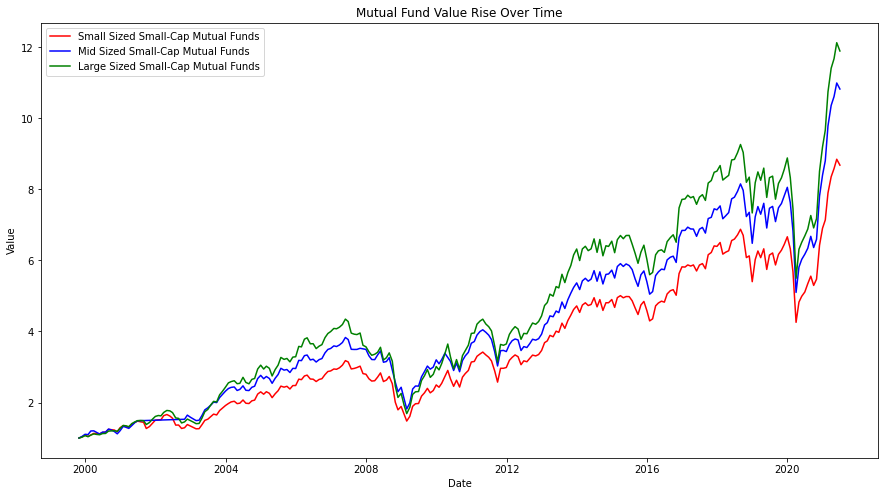

In [25]:
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,8))

ax.plot(df_fund_small['value'], color = 'r', label = 'Small Sized Small-Cap Mutual Funds')
ax.plot(df_fund_mid['value'], color = 'b', label = 'Mid Sized Small-Cap Mutual Funds')
ax.plot(df_fund_large['value'], color = 'g', label = 'Large Sized Small-Cap Mutual Funds')
ax.legend()
ax.set_title('Mutual Fund Value Rise Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.show()

### Mean Average

In [26]:
# Aggregating DataFrame by Fund Group and Month
df_fund_returns_group = df_fund_returns_agg.groupby(['fund_group', 'year_month']).agg({'mtna': np.mean, 'mret': np.mean, 'caldt': max}).reset_index().rename(columns = {'caldt': 'Date'}).dropna(how = 'any')

df_fund_small = df_fund_returns_group[df_fund_returns_group['fund_group'] == 'Small'][['mtna', 'mret', 'Date']].set_index('Date').dropna(how = 'any')
df_fund_mid = df_fund_returns_group[df_fund_returns_group['fund_group'] == 'Mid'][['mtna', 'mret', 'Date']].set_index('Date').dropna(how = 'any')
# df_fund_mid_large = df_fund_returns_group[df_fund_returns_group['fund_group'] == 'Mid-Large'][['mtna', 'mret', 'Date']].set_index('Date').dropna(how = 'any')
df_fund_large = df_fund_returns_group[df_fund_returns_group['fund_group'] == 'Large'][['mtna', 'mret', 'Date']].set_index('Date').dropna(how = 'any')

# df_fund_merged = df_fund_small.merge(df_fund_mid_small, left_index = True, right_index = True, suffixes = ('_small', '_midsmall')) \
#                               .merge(df_fund_mid_large, left_index = True, right_index = True) \
#                               .merge(df_fund_large, left_index = True, right_index = True, suffixes = ('_midlarge', '_large'))

# df_fund_returns_group[df_fund_returns_group['fund_group'] == 'Mid-Large']
df_fund_large

,mtna,mret
Date,,
1999-10-29,6765.200000,-0.009700
1999-11-30,6701.600000,0.025187
1999-12-31,6646.300000,0.041943
2000-01-31,6177.500000,-0.028269
2000-02-29,6187.200000,0.042727
...,...,...
2021-02-26,13651.000000,0.111986
2021-03-31,14672.800000,0.062386
2021-04-30,14862.033333,0.023949


In [ ]:
# value_small = []
# value_mid_small = []
# value_mid_large = []
# value_large = []

# # Calculating Value increase over time, starting with an Arbitrary value of 1 million
# for i in range(0, len(df_fund_merged)):
#     if i == 0:
#         value_small.append(1)
#         value_mid_small.append(1)
#         value_mid_large.append(1)
#         value_large.append(1)
#     else:
#         value_small.append(value_small[i-1] * (1 + df_fund_merged['mret_small'][i]))
#         value_mid_small.append(value_mid_small[i-1] * (1 + df_fund_merged['mret_midsmall'][i]))
#         value_mid_large.append(value_mid_large[i-1] * (1 + df_fund_merged['mret_midlarge'][i]))
#         value_large.append(value_large[i-1] * (1 + df_fund_merged['mret_large'][i]))

# df_fund_returns_final = df_fund_merged.copy()
# df_fund_returns_final['value_small'] = value_small
# df_fund_returns_final['value_mid_small'] = value_mid_small
# df_fund_returns_final['value_mid_large'] = value_mid_large
# df_fund_returns_final['value_large'] = value_large

# df_fund_returns_final

In [27]:
value_small = [1]
value_mid = [1]
value_large = [1]

# temp_small = 1 / df_fund_small['mtna'].iloc[0]
# temp_mid = 1 / df_fund_mid['mtna'].iloc[0]
# temp_large = 1 / df_fund_large['mtna'].iloc[0]

# Calculating Value increase over time, starting with an Arbitrary value of 1 million
for i in range(1, len(df_fund_small)):
    value_small.append(value_small[i-1] * (1 + df_fund_small['mret'][i]))
#     value_small.append(df_fund_small['mtna'][i] * temp_small)

for i in range(1, len(df_fund_mid)):
    value_mid.append(value_mid[i-1] * (1 + df_fund_mid['mret'][i]))
#     value_mid.append(df_fund_mid['mtna'][i] * temp_mid)
        
for i in range(1, len(df_fund_large)):
    value_large.append(value_large[i-1] * (1 + df_fund_large['mret'][i]))
#     value_large.append(df_fund_large['mtna'][i] * temp_large)
        
df_fund_small['value'] = value_small
df_fund_mid['value'] = value_mid
df_fund_large['value'] = value_large


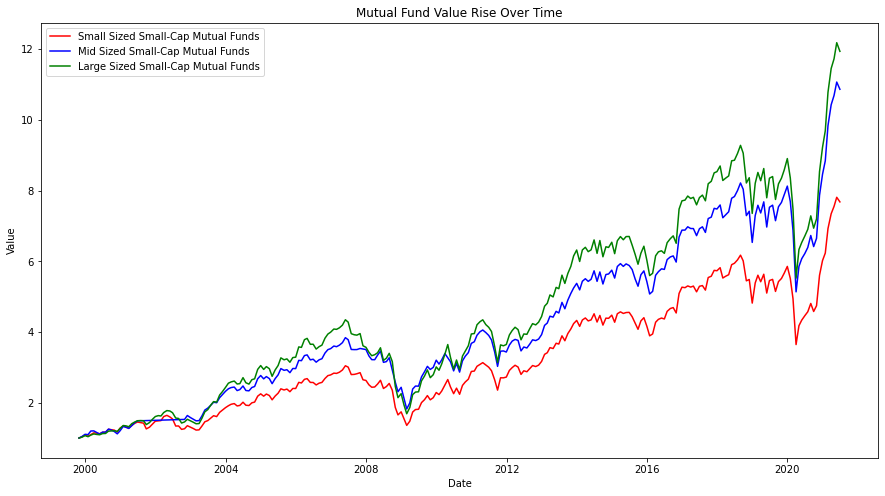

In [28]:
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,8))

ax.plot(df_fund_small['value'], color = 'r', label = 'Small Sized Small-Cap Mutual Funds')
ax.plot(df_fund_mid['value'], color = 'b', label = 'Mid Sized Small-Cap Mutual Funds')
ax.plot(df_fund_large['value'], color = 'g', label = 'Large Sized Small-Cap Mutual Funds')
ax.legend()
ax.set_title('Mutual Fund Value Rise Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.show()